# CellOracle - Cicero workflow

Use Cicero to get co-accessible peak information.

This notebook is executed in an R environment.

## import

In [1]:
library(cicero)
library(Seurat)
library(stringr)
library(reticulate)
library(Matrix)
use_python("/data1/lichen/anaconda3/envs/pytorch2/bin/python") # set a python env with Scanpy package

Loading required package: monocle3

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required pac

## construct input cds

In [2]:
sc <- import("scanpy")
adata <- sc$read_h5ad('./ATAC_data/adata_atac_raw.h5ad')
adata

In [3]:
adata

AnnData object with n_obs × n_vars = 13387 × 246132
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'

In [6]:
# - generate cellinfo and peakinfo

indata=adata$X
peakinfo=adata$var
cellinfo=adata$obs

chr=lapply(row.names(peakinfo),function(x){
    return(str_split(x, "_")[[1]][1])
})
start=lapply(row.names(peakinfo),function(x){
    return(str_split(x, "_")[[1]][2])
})
end=lapply(row.names(peakinfo),function(x){
    return(str_split(x, "_")[[1]][3])
})

cellinfo$V1=row.names(cellinfo)

peakinfo$chr=chr
peakinfo$bp1=start
peakinfo$bp2=end

indata=t(indata)
indata = as.sparse(indata)

row.names(indata) <- row.names(peakinfo)
colnames(indata) <- row.names(cellinfo)
peakinfo=subset(peakinfo,select=c('chr','bp1','bp2'))

In [11]:
# - make CDS
input_cds <-  suppressWarnings(new_cell_data_set(indata,
cell_metadata = cellinfo,
gene_metadata = peakinfo))

input_cds

In [13]:
# - Ensure there are no peaks included with zero reads
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,]

In [14]:
input_cds

class: cell_data_set 
dim: 246132 13387 
metadata(1): cds_version
assays(1): counts
rownames(246132): chr1_819722_820222 chr1_827288_827788 ...
  chrX_155966781_155967281 chrX_155971350_155971850
rowData names(3): chr bp1 bp2
colnames(13387): day00#ACATGCAGTGGCATAG-1 day00#GCTCACTGTAGCATGG-1 ...
  day14#GGCGAAATCATTGCCC-1 day14#TGCTCGTCACAAACGG-1
colData names(20): BlacklistRatio DoubletEnrichment ... V1 Size_Factor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

## Qauality check and Filtering

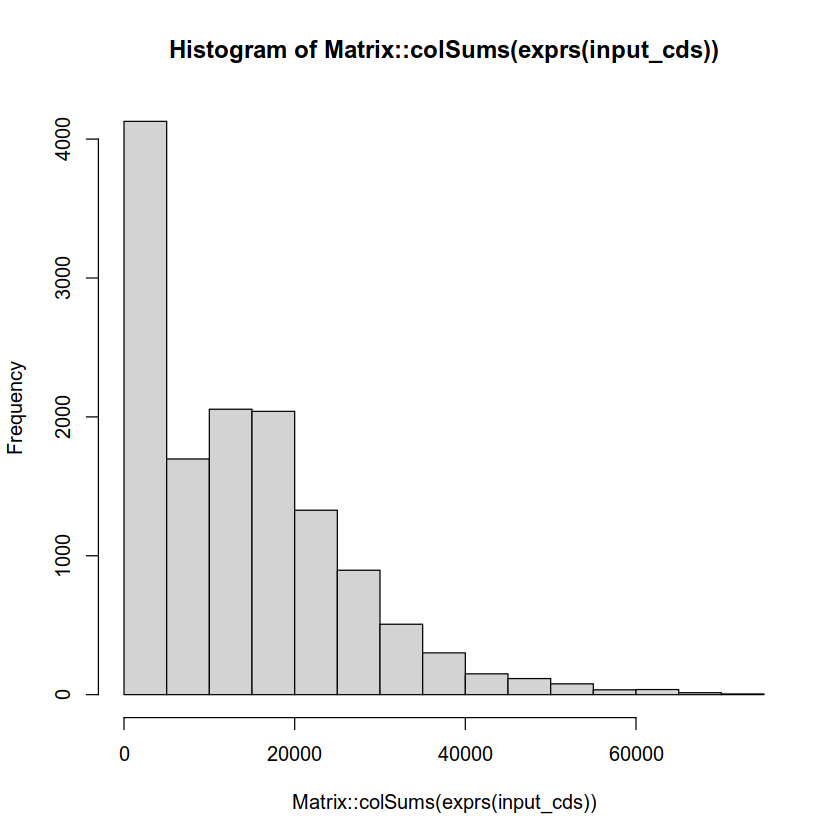

In [15]:
# Visualize peak_count_per_cell
hist(Matrix::colSums(exprs(input_cds)))

## create cicero cds

In [16]:
input_cds_raw=input_cds

In [17]:
set.seed(2022)
input_cds <- detect_genes(input_cds_raw)
input_cds <- estimate_size_factors(input_cds)
input_cds <- preprocess_cds(input_cds, method = "LSI")
input_cds <- reduce_dimension(input_cds, reduction_method = 'UMAP', 
                              preprocess_method = "LSI")

No trajectory to plot. Has learn_graph() been called yet?



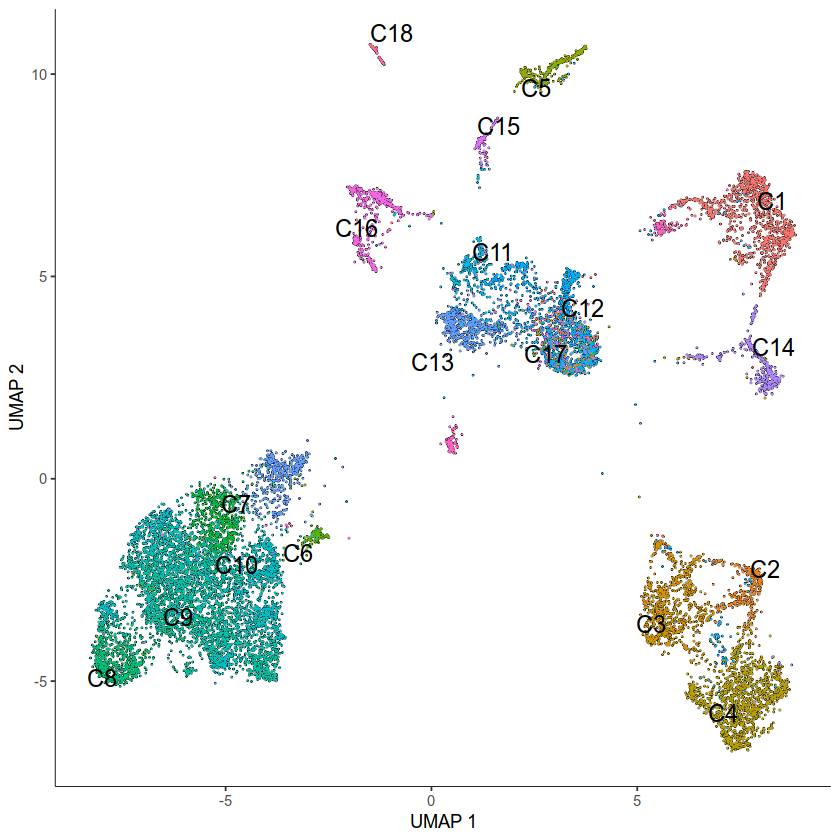

In [18]:
plot_cells(input_cds, color_cells_by = "Clusters",group_label_size=5)

In [19]:
umap_coords <- reducedDims(input_cds)$UMAP
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_coords)

Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 0.196795882526791
Median shared cells bin-bin: 0



## run cicero

If the refrence genome is mm10 or hg38, download the chrom size files from xxxx.

If the refrence genome is mm9 or hg19, you can directly load the data by 'data("mouse.mm9.genome")' or 'data("human.hg19.genome")'

In [20]:
temp='/data1/lichen/code/second/scATAC_integration/data/gene_file/hg38.chrom.sizes.txt'
human.hg38.genome <- read.table(temp)

# temp='/data1/lichen/code/second/scATAC_integration/data/gene_file/mm10.chrom.sizes.txt'
# mouse.mm10.genome <- read.table(temp)

# data("mouse.mm9.genome")
# data("human.hg19.genome")

In [ ]:
# - run_cicero will spend hours based on the data size

sample_genome <- human.hg38.genome
## Usually run with sample_num = 100 ##
conns <- run_cicero(cicero_cds, sample_genome, sample_num = 100) 
head(conns)
dim(conns)

In [2]:
# - save data

datadir <- sprintf('./base_GRN')
system(sprintf("mkdir -p %s", datadir))

all_peaks <- row.names(exprs(input_cds))
write.csv(x = all_peaks, file = paste0(datadir, "/all_peaks_stream.csv"))
write.csv(x = conns, file = paste0(datadir, "/cicero_connections_stream.csv"))